In [1]:
BASEPATH = "shopping_coco"
IMAGEPATH = "images"
ANNOTATIONSFILE = "annotations/values_images.csv"

In [2]:
import json
import os

In [3]:
IMAGES = os.path.join(BASEPATH, IMAGEPATH)
ANNOTATIONS = os.path.join(BASEPATH, ANNOTATIONSFILE)

In [4]:
import pandas as pd
annotations = None

annotations = pd.read_csv(ANNOTATIONS)
annotations["Value"] = pd.to_numeric(annotations["Value"].str.replace(',', '.'),errors='coerce')
#annotations = annotations.drop_duplicates(subset=["file_name"]) # drop all doubly annotated images
annotations.head()

,File,Value
0,photo_1@02-05-2020_11-15-55.jpg,35.85
1,photo_2@02-05-2020_13-25-27.jpg,2.48
2,photo_3@02-05-2020_13-26-13.jpg,5.35
3,photo_4@02-05-2020_13-26-49.jpg,2.97
4,photo_5@04-05-2020_09-53-52.jpg,2.64


In [32]:
SOURCEDIMS = (960, 1280)
TARGETDIMS = (480, 640) #(height, width)
SCALING_FACTOR_Y = SOURCEDIMS[0] / TARGETDIMS[0]
SCALING_FACTOR_X = SOURCEDIMS[1] / TARGETDIMS[1]
SCALING_FACTORS = [SCALING_FACTOR_X, SCALING_FACTOR_Y, SCALING_FACTOR_X, SCALING_FACTOR_Y]
BBOX_SCALING_FACTORS = [SOURCEDIMS[0], SOURCEDIMS[1], SOURCEDIMS[0], SOURCEDIMS[1]]
display(SCALING_FACTORS)

[2.0, 2.0, 2.0, 2.0]

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
tf.__version__

'2.5.0'

In [85]:
images = []
values = []
for idx, row in annotations.iterrows():
    path = os.path.join(IMAGES, row["File"])
    image = (np.array(tf.keras.preprocessing.image.load_img(path, target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) 
    value = row["Value"]
    images.append(image)
    values.append(value)

images = np.array(images)
values = np.array(values)
    

display("Loaded " + str(len(images)) + " images and " + str(len(values)) + " values")

'Loaded 447 images and 447 values'

In [86]:
images[0]

array([[[0.5751634 ],
        [0.56732026],
        [0.56732026],
        ...,
        [0.78300654],
        [0.74771242],
        [0.7124183 ]],

       [[0.5751634 ],
        [0.5751634 ],
        [0.5751634 ],
        ...,
        [0.84444444],
        [0.82614379],
        [0.8130719 ]],

       [[0.57908497],
        [0.5751634 ],
        [0.5751634 ],
        ...,
        [0.85490196],
        [0.84836601],
        [0.83921569]],

       ...,

       [[0.11111111],
        [0.10588235],
        [0.1124183 ],
        ...,
        [0.15424837],
        [0.1503268 ],
        [0.1503268 ]],

       [[0.11503268],
        [0.10718954],
        [0.10065359],
        ...,
        [0.14901961],
        [0.14771242],
        [0.14509804]],

       [[0.14509804],
        [0.11633987],
        [0.09803922],
        ...,
        [0.13594771],
        [0.14248366],
        [0.14379085]]])

In [168]:
import tensorflow.keras.layers as K
model = tf.keras.Sequential()
model.add(K.InputLayer((TARGETDIMS[0], TARGETDIMS[1], 1)))
model.add(K.Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(K.MaxPool2D(pool_size=(2,2)))
#model.add(K.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
#model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Flatten())
model.add(K.Dense(256, activation="relu"))
#model.add(K.Dropout(rate=0.1))
model.add(K.Dense(128, activation="relu"))
#model.add(K.Dropout(rate=0.1))
model.add(K.Dense(64, activation="relu"))
#model.add(K.Dropout(rate=0.1))
model.add(K.Dense(32, activation="relu"))
#model.add(K.Dropout(rate=0.1))
model.add(K.Dense(16, activation="relu"))
#model.add(K.Dropout(rate=0.1))
model.add(K.Dense(1, activation="relu"))
model.build()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 478, 638, 16)      160       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 239, 319, 16)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 237, 317, 32)      4640      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 118, 158, 32)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 116, 156, 64)      18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 58, 78, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 289536)          

In [183]:
imagedata = tf.data.Dataset.from_tensor_slices((images, values))

#imagedata = imagedata.repeat(100).shuffle(100).batch(10)

imagedata = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1
)

training = imagedata.flow(images, values, batch_size=10)
validation = imagedata.flow(images, values, batch_size=10)

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
history = model.fit(training, epochs=1000, steps_per_epoch=10)

Epoch 1/1000
10/10 [==============================] - 2s 156ms/step - loss: 68.9211 - mean_absolute_error: 5.7733
Epoch 2/1000
10/10 [==============================] - 2s 159ms/step - loss: 49.4398 - mean_absolute_error: 5.4035
Epoch 3/1000
10/10 [==============================] - 2s 155ms/step - loss: 55.8374 - mean_absolute_error: 5.9523
Epoch 4/1000
10/10 [==============================] - 2s 156ms/step - loss: 42.5851 - mean_absolute_error: 5.1204
Epoch 5/1000
10/10 [==============================] - 2s 153ms/step - loss: 66.3421 - mean_absolute_error: 5.9371
Epoch 6/1000
10/10 [==============================] - 2s 154ms/step - loss: 40.7334 - mean_absolute_error: 4.7399
Epoch 7/1000
10/10 [==============================] - 2s 154ms/step - loss: 61.7890 - mean_absolute_error: 5.8795
Epoch 8/1000
10/10 [==============================] - 2s 154ms/step - loss: 57.8983 - mean_absolute_error: 5.2510
Epoch 9/1000
10/10 [==============================] - 2s 154ms/step - loss: 46.6497 - me

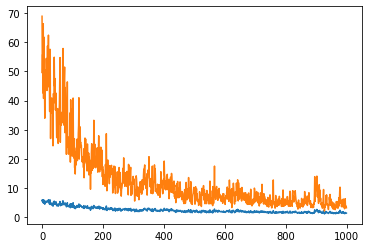

In [184]:
plt.figure()
plt.plot(history.history["mean_absolute_error"])
plt.plot(history.history["loss"])
plt.show()

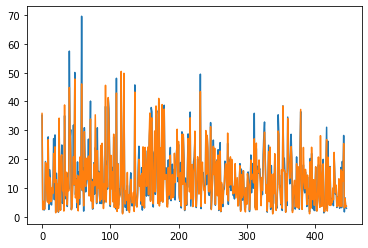

In [185]:
predictions = model.predict(images)
diff = np.abs(predictions - values)
#plt.hist(diff)
plt.plot(predictions)
plt.plot(values)

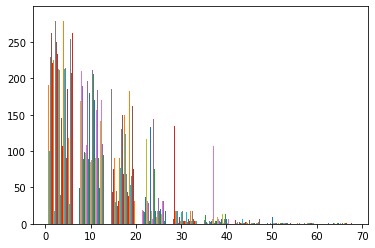

In [186]:
plt.hist(diff, bins=10)
plt.show()

In [188]:
df = annotations.copy()
df["Predictions"] = predictions
df["Diff"] = np.abs(df["Value"] - df["Predictions"])
df = df.sort_values("Diff", ascending=False)
df

,File,Value,Predictions,Diff
58,photo_59@02-07-2020_14-21-16.jpg,46.09,69.576981,23.486981
40,photo_41@13-06-2020_19-25-47.jpg,44.86,57.483154,12.623154
78,photo_79@18-07-2020_12-20-13.jpg,35.38,24.005575,11.374425
46,photo_47@18-06-2020_19-33-54.jpg,20.82,31.810614,10.990614
408,photo_417@25-09-2021_14-36-54.jpg,28.15,18.102680,10.047320
...,...,...,...,...
415,photo_424@28-09-2021_17-53-23.jpg,3.18,3.207471,0.027471
295,photo_300@25-04-2021_10-43-31.jpg,15.94,15.964162,0.024162
353,photo_359@02-07-2021_12-50-31.jpg,38.45,38.471642,0.021642
264,photo_269@20-03-2021_17-50-49.jpg,4.75,4.739193,0.010807


In [1]:
validation_image = (np.array(tf.keras.preprocessing.image.load_img("validation/photo_2022-01-03_17-48-12.jpg", target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) # real value is 22€
#validation_image = (np.array(tf.keras.preprocessing.image.load_img("validation/photo_2021-12-18_17-59-03.jpg", target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) # real value is 2.84
#validation_image = (np.array(tf.keras.preprocessing.image.load_img("validation/photo_2021-12-09_18-21-08.jpg", target_size=TARGETDIMS, interpolation="bicubic"))/ 255.0).mean(axis=2,keepdims=True) # real value is 10.82

validation_image.shape

NameError: name 'np' is not defined

In [196]:
model.predict(np.array([validation_image]))

array([[17.628162]], dtype=float32)

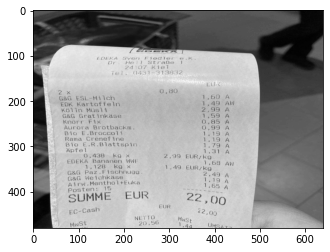

In [197]:
plt.imshow(validation_image,cmap="gray")